In [1]:
import sys
sys.path.append("..")
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from dory.linear.ols import OrdinaryLeastSquaresRegressor
from dory.linear.gd import GradientDescentRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dory.linear import StochasticGradientDescentRegressor
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
artificial_df = pd.read_csv("artificial1d.csv", header=None)
artificial_df.describe()

def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    error = y_true - y_pred
    return np.mean(error ** 2)

In [3]:
X = artificial_df.iloc[:, :-1].to_numpy()
y = artificial_df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24, 1) (6, 1) (24,) (6,)


In [4]:
ols_pipeline = Pipeline([
    ("linear", OrdinaryLeastSquaresRegressor())
])
ols_pipeline

,steps,"[('linear', ...)]"
,transform_input,None
,memory,None
,verbose,False
,fit_intercept,True
,l2_alpha,0.0


/var/folders/bj/s5pcvzbn6kxbfc_lky95q7400000gn/T/ipykernel_77339/3623744327.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


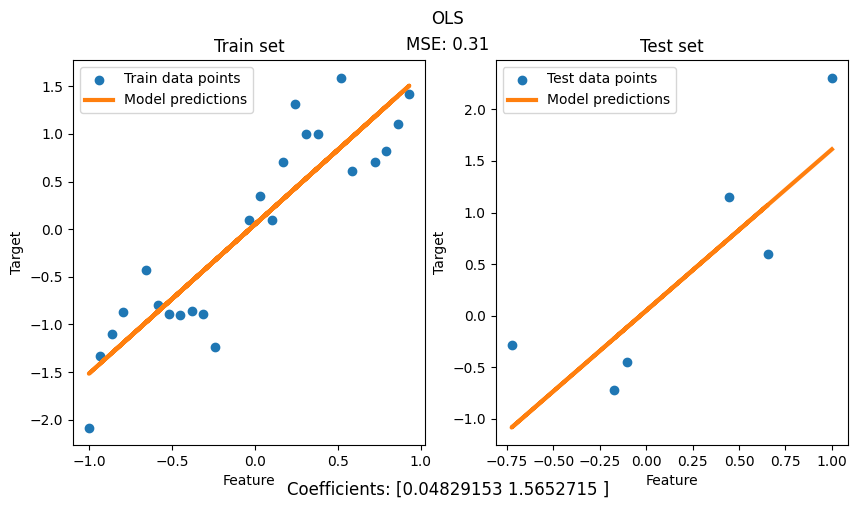

In [5]:
# TODO: Check if this y_pred is normalized and denormalized if needed
y_pred = ols_pipeline.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, y_pred)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].scatter(X_train, y_train, label="Train data points")
ax[0].plot(
    X_train,
    ols_pipeline.predict(X_train),
    linewidth=3,
    color="tab:orange",
    label="Model predictions",
)
ax[0].set(xlabel="Feature", ylabel="Target", title="Train set")
ax[0].legend()

ax[1].scatter(X_test, y_test, label="Test data points")
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")
ax[1].set(xlabel="Feature", ylabel="Target", title="Test set")
ax[1].legend()

fig.suptitle("OLS")
fig.text(0.5, 0.9, f'MSE: {mse:.2f}',fontsize=12, horizontalalignment='center')
fig.text(0.5, 0.01, f'Coefficients: {ols_pipeline.named_steps["linear"].w_}',fontsize=12, horizontalalignment='center')


fig.show()

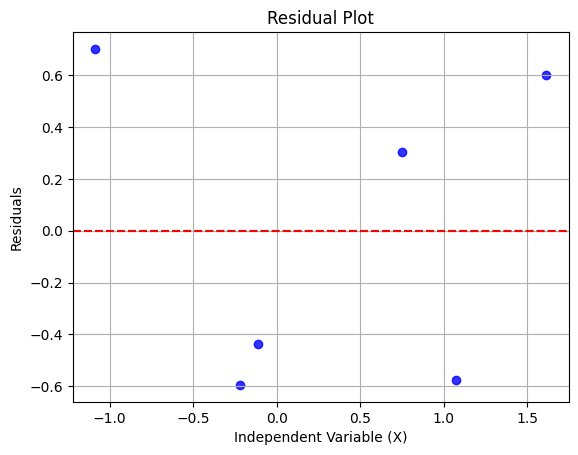

In [6]:
sns.residplot(x=y_pred, y=y_test, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [7]:
epochs = 100
initial_weights = [10.0, 10.0]
gd_pipe = Pipeline(
    [
        (
            "gd",
            GradientDescentRegressor(
                epochs=epochs,
                initial_weights=np.array(initial_weights),
                alpha=0.1,
            ),
        )
    ]
)
gd_pipe

,steps,"[('gd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epochs,100
,epsilon,0.1
,alpha,0.1
,shuffle,True
,seed,42069
,initial_weights,"array([10., 10.])"
,validation_fraction,0.1


INFO:dory.linear.gd:Epoch 0 completed. Train loss: 107.18366736306845, Val loss: 183.219519575524, weights: [[9.08456981 9.80451975]]
INFO:dory.linear.gd:Epoch 1 completed. Train loss: 90.47792015882648, Val loss: 158.8526371467, weights: [[8.25891721 9.60745411]]
INFO:dory.linear.gd:Epoch 2 completed. Train loss: 76.73276673497483, Val loss: 138.25864895155973, weights: [[7.51405014 9.40966807]]
INFO:dory.linear.gd:Epoch 3 completed. Train loss: 65.39542983780537, Val loss: 120.80124180316052, weights: [[6.84188352 9.21191583]]
INFO:dory.linear.gd:Epoch 4 completed. Train loss: 56.01831824282184, Val loss: 105.95669439673797, weights: [[6.23514763 9.01485282]]
INFO:dory.linear.gd:Epoch 5 completed. Train loss: 48.23887937823391, Val loss: 93.29338149441632, weights: [[5.68730562 8.8190464 ]]
INFO:dory.linear.gd:Epoch 6 completed. Train loss: 41.763319623962765, Val loss: 82.45507618542082, weights: [[5.19247944 8.62498549]]
INFO:dory.linear.gd:Epoch 7 completed. Train loss: 36.3534492

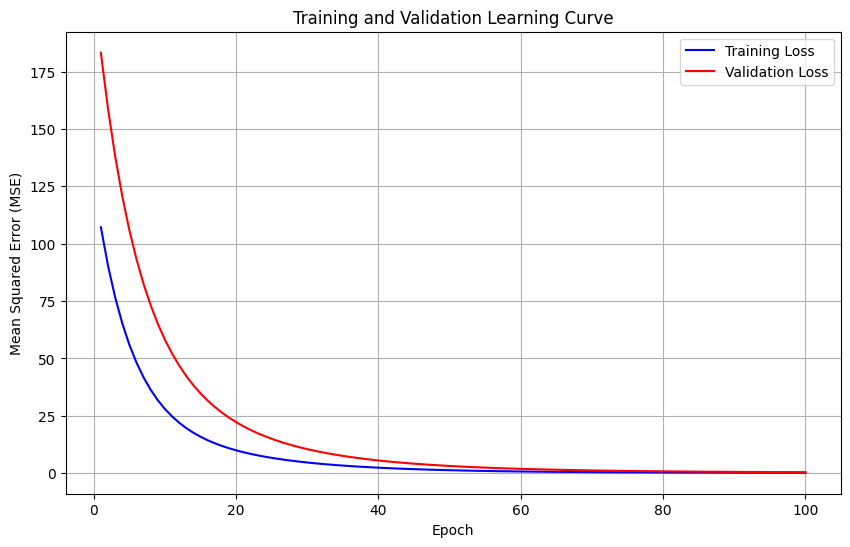

In [8]:
gd: GradientDescentRegressor = gd_pipe.named_steps["gd"]
y_pred = gd_pipe.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, y_pred)
epochs_range = range(1, epochs+1)

validation_loss = gd.history_["val_loss"]
train_loss = gd.history_["train_loss"]


plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, validation_loss, label='Validation Loss', color='red')

plt.title('Training and Validation Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

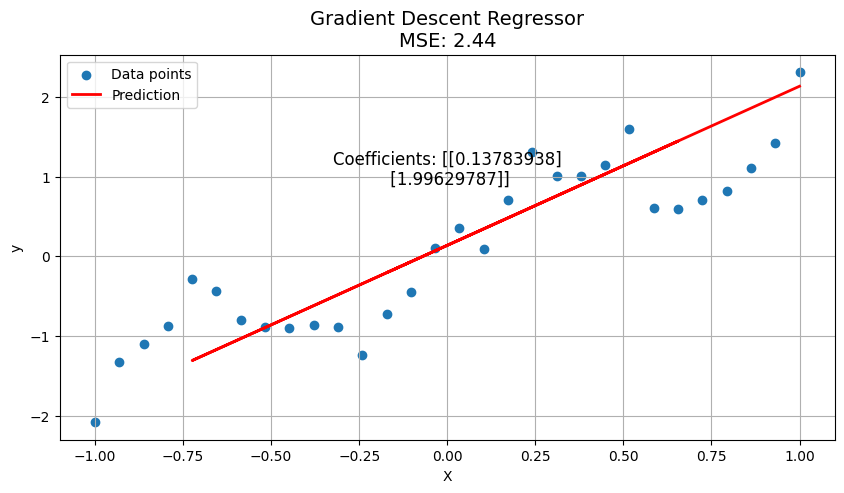

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Data points")
plt.plot(X_test, y_pred, "r-", linewidth=2, label="Prediction")
plt.xlabel("X")
plt.ylabel("y")

mse = mean_squared_error(y_test, y_pred)
plt.title(f"Gradient Descent Regressor\nMSE: {mse:.2f}", fontsize=14)
plt.text(0.0, 0.9, f'Coefficients: {gd.weights_}',fontsize=12, horizontalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

In [10]:
sgd_epochs = 100
sgd_pipe = Pipeline(
    [
        (
            "sgd",
            StochasticGradientDescentRegressor(
                epochs=sgd_epochs,
                initial_weights=np.array(initial_weights),
                alpha=0.01,
                epsilon=0.0001,
                batch_size=10,
            ),
        )
    ]
)

sgd_pipe

,steps,"[('sgd', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epochs,100
,epsilon,0.0001
,alpha,0.01
,shuffle,True
,seed,42069
,initial_weights,"array([10., 10.])"
,validation_fraction,0.1


INFO:dory.linear.sgd:Epoch 0 completed. Train loss: 111.02416165903477, Val loss: 158.53611182352253, weights: [[9.07859752 9.79004949]]
INFO:dory.linear.sgd:Epoch 1 completed. Train loss: 74.60487061866377, Val loss: 140.16307635306612, weights: [[8.2673404  9.75271938]]
INFO:dory.linear.sgd:Epoch 2 completed. Train loss: 78.17118040725153, Val loss: 122.7167629508367, weights: [[7.53238108 9.54719556]]
INFO:dory.linear.sgd:Epoch 3 completed. Train loss: 82.30913442642795, Val loss: 104.40259887296236, weights: [[6.72046091 9.27114108]]
INFO:dory.linear.sgd:Epoch 4 completed. Train loss: 59.64798327938051, Val loss: 91.4656937181977, weights: [[6.117804   9.02776538]]
INFO:dory.linear.sgd:Epoch 5 completed. Train loss: 50.496008836001394, Val loss: 79.96288627620528, weights: [[5.51979041 8.82887004]]
INFO:dory.linear.sgd:Epoch 6 completed. Train loss: 40.97418411543366, Val loss: 70.54530865871386, weights: [[4.98717064 8.66146048]]
INFO:dory.linear.sgd:Epoch 7 completed. Train loss:

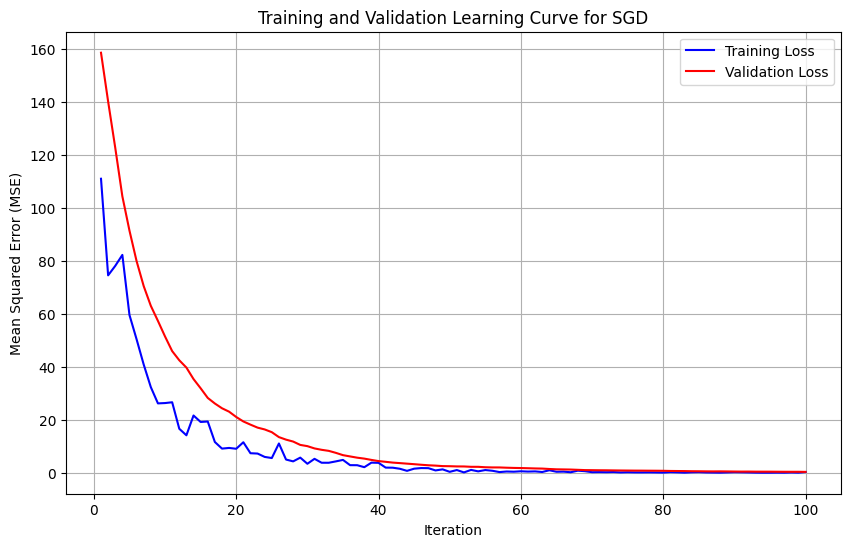

In [11]:
y_pred = sgd_pipe.fit(X_train, y_train).predict(X_test)
sgd: StochasticGradientDescentRegressor = sgd_pipe.named_steps["sgd"]
mse = mean_squared_error(y_test, y_pred)


validation_loss = sgd.history_["val_loss"]
train_loss = sgd.history_["train_loss"]

iterations = range(1, (train_loss.size) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, train_loss, label="Training Loss", color="blue")
plt.plot(iterations, validation_loss, label="Validation Loss", color="red")

plt.title("Training and Validation Learning Curve for SGD")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()

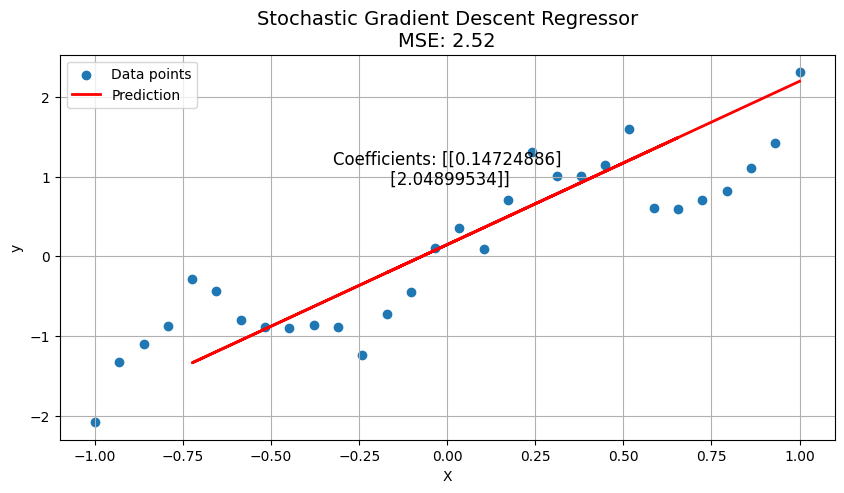

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Data points")
plt.plot(X_test, y_pred, "r-", linewidth=2, label="Prediction")
plt.xlabel("X")
plt.ylabel("y")

mse = mean_squared_error(y_test, y_pred)
plt.title(f"Stochastic Gradient Descent Regressor\nMSE: {mse:.2f}", fontsize=14)
plt.text(0.0, 0.9, f'Coefficients: {sgd.weights_}',fontsize=12, horizontalalignment='center')

plt.legend()
plt.grid(True)
plt.show()